Setup & Kaggle Authentication for dataset

In [ ]:
!pip install -q kaggle tensorflow matplotlib seaborn scikit-learn shap

import os, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from google.colab import files
from sklearn.metrics import classification_report, confusion_matrix
print("Upload kaggle.json")
files.upload()

os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


Upload kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!rm -rf data
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset
!unzip -q augmented-alzheimer-mri-dataset.zip -d data


Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset
License(s): GNU Lesser General Public License 3.0
 87% 330M/380M [00:00<00:00, 642MB/s]
100% 380M/380M [00:00<00:00, 619MB/s]


Data Generators

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input

IMG_SIZE = (224,224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    "data/OriginalDataset",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    "data/OriginalDataset",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
print("Classes:", class_names)


Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


Class Weights (Bias-Aware)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

y_train = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight = dict(enumerate(class_weights))
print("Class Weights:", class_weight)


Class Weights: {0: np.float64(1.7855648535564854), 1: np.float64(24.620192307692307), 2: np.float64(0.50009765625), 3: np.float64(0.7144252232142857)}


DenseNet121 Model

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

for layer in base_model.layers[:-40]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

output = Dense(4, activation="softmax")(x)

model = Model(base_model.input, output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,697,732 (29.36 MB)

 Trainable params: 1,486,404 (5.67 MB)

 Non-trainable params: 6,211,328 (23.69 MB)

Train Model

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    class_weight=class_weight
)

model.save("alzheimer_research_model.keras")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
161/161 ━━━━━━━━━━━━━━━━━━━━ 198s 942ms/step - accuracy: 0.2914 - loss: 2.1048 - val_accuracy: 0.4378 - val_loss: 1.2882
Epoch 2/25
161/161 ━━━━━━━━━━━━━━━━━━━━ 85s 531ms/step - accuracy: 0.3768 - loss: 1.4111 - val_accuracy: 0.3909 - val_loss: 1.4439
Epoch 3/25
161/161 ━━━━━━━━━━━━━━━━━━━━ 78s 486ms/step - accuracy: 0.3954 - loss: 1.2788 - val_accuracy: 0.3088 - val_loss: 1.6444
Epoch 4/25
161/161 ━━━━━━━━━━━━━━━━━━━━ 78s 485ms/step - accuracy: 0.4353 - loss: 1.2215 - val_accuracy: 0.3643 - val_loss: 1.5123
Epoch 5/25
161/161 ━━━━━━━━━━━━━━━━━━━━ 77s 479ms/step - accuracy: 0.4523 - loss: 1.1498 - val_accuracy: 0.2447 - val_loss: 2.1003
Epoch 6/25
161/161 ━━━━━━━━━━━━━━━━━━━━ 77s 478ms/step - accuracy: 0.4798 - loss: 1.0763 - val_accuracy: 0.4167 - val_loss: 1.3798
Epoch 7/25
161/161 ━━━━━━━━━━━━━━━━━━━━ 77s 482ms/step - accuracy: 0.4889 - loss: 1.0088 - val_accuracy: 0.4480 - val_loss: 1.3723
Epoch 8/25
161/161 ━━━━━━━━━━━━━━━━━━━━ 77s 478ms/step - accuracy: 0.5134 - loss: 

Model Evaluation

In [ ]:
pred_probs = model.predict(val_gen)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_gen.classes

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))


40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 656ms/step
                  precision    recall  f1-score   support

    MildDemented       0.51      0.45      0.48       179
ModerateDemented       0.28      0.92      0.42        12
     NonDemented       0.81      0.60      0.69       640
VeryMildDemented       0.54      0.73      0.62       448

        accuracy                           0.63      1279
       macro avg       0.53      0.67      0.55      1279
    weighted avg       0.67      0.63      0.63      1279



Confusion Matrix

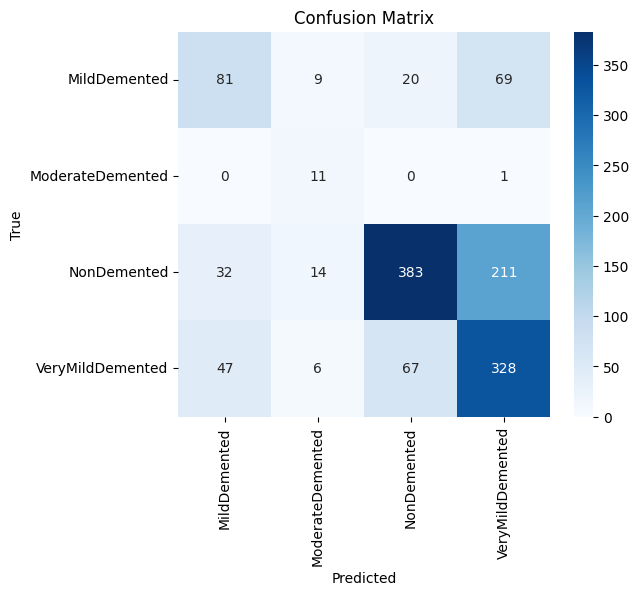

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Bias Gap Index (BGI)

In [ ]:
mean_probs = pred_probs.mean(axis=0)
BGI = np.max(mean_probs) - np.min(mean_probs)

print("Bias Gap Index (BGI):", round(BGI, 4))


Bias Gap Index (BGI): 0.3919


SHAP Explainability

/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(20, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(40, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(3, 224, 224, 3

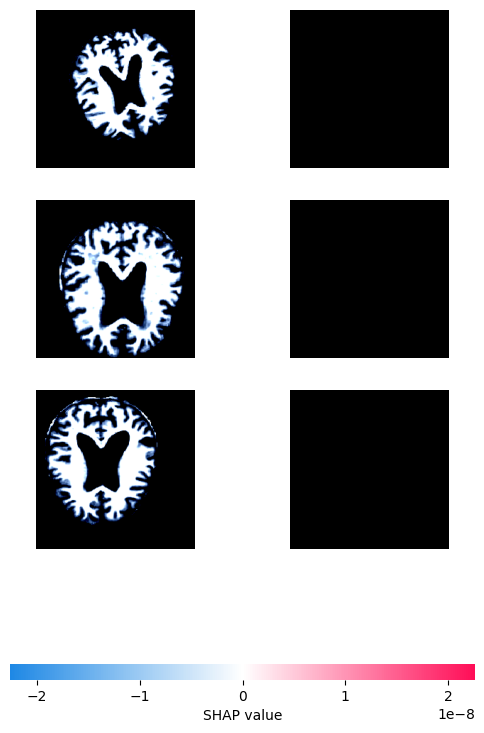

In [ ]:
import shap

# Take small background to avoid memory issues
background, _ = next(train_gen)
background = background[:20]

explainer = shap.DeepExplainer(model, background)

test_images, _ = next(val_gen)
test_images = test_images[:3]

shap_values = explainer.shap_values(test_images)

shap.image_plot(shap_values, test_images)


Grad-CAM

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


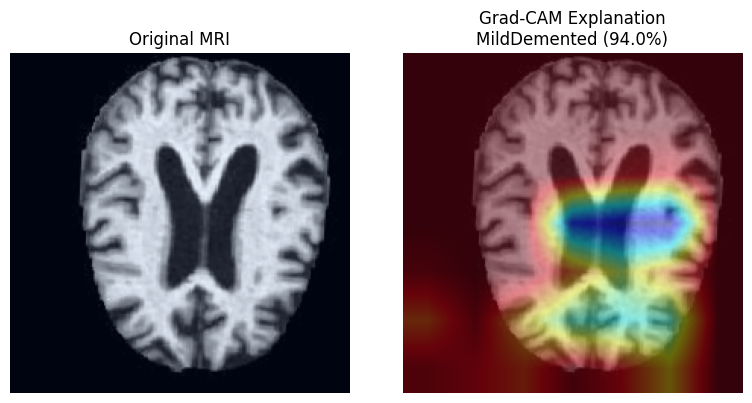

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

# ---- STEP 1: Grad-CAM function (clean & correct) ----
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap.numpy(), int(class_idx), float(predictions[0][class_idx])

    # ---- STEP 2: Pick ONE MRI image (validation set) ----
img_batch, label_batch = val_gen[0]
img = img_batch[0]
img_input = np.expand_dims(img, axis=0)

# ---- STEP 3: Generate Grad-CAM ----
heatmap, pred_class, confidence = make_gradcam_heatmap(
    img_input,
    model,
    last_conv_layer_name="conv5_block16_concat"  # DenseNet121
)

pred_label = class_names[pred_class]
confidence *= 100

# ---- STEP 4: Create clean overlay (THIS IS THE KEY PART) ----
# Resize heatmap
heatmap = cv2.resize(heatmap, (224, 224))

# Convert to color
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Prepare original image
orig = img.copy()
orig = (orig - orig.min()) / (orig.max() - orig.min())
orig = np.uint8(255 * orig)

# Overlay
superimposed = cv2.addWeighted(orig, 0.6, heatmap, 0.4, 0)

# ---- STEP 5: Plot EXACTLY like your example ----
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(orig)
plt.title("Original MRI")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(superimposed)
plt.title(f"Grad-CAM Explanation\n{pred_label} ({confidence:.1f}%)")
plt.axis("off")

plt.tight_layout()
plt.show()


